In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from utils.retinet import QRetiNet
import torch
import torch.nn as nn
from torchvision.models import resnet50
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path = 'logs/version4/checkpoints/model.pth'
model = torch.load(path)
mode = model.to('cuda')
# x = [module for module in model.modules() if not isinstance(module, nn.Sequential)]
target_layers = [model.layers.conv6]
print(target_layers)


[Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))]


torch.Size([1, 3, 224, 224])


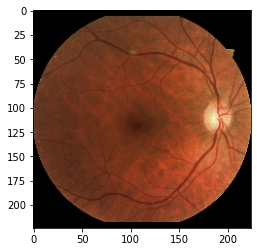

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
rgb = cv2.imread('dataset/D2/val/1/12678_right.jpeg')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = cv2.resize(rgb, (224,224))
rgb = np.array(rgb) / 255.
plt.figure()
plt.imshow(rgb)
image = rgb.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)

input_tensor = torch.Tensor(image).to('cuda')
print(input_tensor.size())



torch.Size([3, 224, 224])


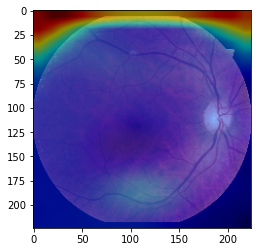

In [10]:
import torch
from PIL import Image
cam = GradCAM(model, target_layers, use_cuda=True)
rgb = input_tensor.detach().cpu()
grayscale_cam = cam(input_tensor=rgb, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb.squeeze(0).numpy().transpose(1, 2, 0), grayscale_cam, use_rgb=True)
vis_img = Image.fromarray(visualization).convert('RGB')
vis_tensor = torch.tensor(visualization.transpose(2, 0, 1), dtype=torch.float, device='cuda')
print(vis_tensor.size())
plt.figure()
plt.imshow(np.array(vis_img))
